### Cancer Survival Experiment PFS

In [1]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import lifelines
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import statsmodels.stats.multitest as multi
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from lifelines.statistics import logrank_test

In [4]:
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from scipy import stats

In [5]:
import json
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [6]:
random_state=75

In [7]:
def make_surv_df(surv,surv_type,raw):
    
    '''
    make TCGA survival dataframe
    '''
    
    #get survival dataframe
    surv=pd.read_csv(surv,index_col=0)
    surv=surv.rename(columns={"bcr_patient_barcode":"FID"})
    surv=surv[surv["Redaction"].isnull()]
    
    #get phenos
    raw=pd.read_csv(raw,delim_whitespace=True,index_col=0)
    raw=raw.iloc[:,5:]
    raw=raw.reset_index()
    raw=raw.rename(columns={"index":"FID"})

    #combine dataframes
    full_surv=pd.merge(surv[["FID",surv_type,surv_type+".time","age_at_initial_pathologic_diagnosis","race","gender","ajcc_pathologic_tumor_stage"]], raw, on="FID", how="left")
    #full_surv=full_surv[full_surv[surv_type+".time"]<1825] #censor at 5 years
    #get patients with Stage designations
    full_surv=full_surv[full_surv["ajcc_pathologic_tumor_stage"].str.contains("Stage")]
    full_surv=full_surv[~(full_surv["ajcc_pathologic_tumor_stage"].isin(["Stage X"]))]
    #split A,B,C from stage designations
    full_surv["ajcc_pathologic_tumor_stage"]=full_surv["ajcc_pathologic_tumor_stage"].str.split("A").str[0]
    full_surv["ajcc_pathologic_tumor_stage"]=full_surv["ajcc_pathologic_tumor_stage"].str.split("B").str[0]
    full_surv["ajcc_pathologic_tumor_stage"]=full_surv["ajcc_pathologic_tumor_stage"].str.split("C").str[0]
    print(full_surv.shape)
    full_surv=full_surv.join(pd.get_dummies(full_surv["ajcc_pathologic_tumor_stage"]))
    #remap gender
    full_surv["gender"]=full_surv["gender"].map({"MALE":0,"FEMALE":1})
    
    full_surv=full_surv[~full_surv[surv_type].isnull()]
    full_surv=full_surv[~full_surv[surv_type+".time"].isnull()]
    
    full_surv=full_surv[~full_surv["age_at_initial_pathologic_diagnosis"].isnull()]
    
    #map to cancer type
    canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
    mp = canc.set_index(2)[0].to_dict()
    full_surv["cancer"]=full_surv["FID"].map(mp)
    full_surv=full_surv[~full_surv["cancer"].isnull()]
    
    full_surv['ajcc_pathologic_tumor_stage'] = full_surv['ajcc_pathologic_tumor_stage'].replace({'Stage 0':0,'Stage I': 1,'Stage II': 2,'Stage III': 3,'Stage IV': 4})
    
    return(full_surv)

In [8]:
def run_surv_plot(df_annot,surv_df,surv_type,out):
    
    '''
    plot kaplan meier for each snp in df_annot
    '''
    for i,row in df_annot.iterrows():
        try:
            surv_df_canc=surv_df[surv_df["cancer"]==row["cancer"]]
            x=[x for x in surv_df.columns if row["snps"].rsplit(":",2)[0] in x][0]
            rs=x.rsplit(":",2)[0]
        
            allele1=x.split(":")[2]
            allele2=str(x.split("_")[0]).split(":")[3]
            minor=x.split("_")[1]
            if allele1 == minor:
                major=allele2
            else:
                major=allele1
            
            fig=plt.figure(figsize=(12,5))
            ax1 = plt.subplot(1,2,1)
            
            groups = surv_df_canc[x]
            ix0 = (groups == 0)
            ix1 = (groups == 1)
            ix2 = (groups == 2)

            kmf = KaplanMeierFitter()
            kmf.fit(surv_df_canc[surv_type+'.time'][ix2], surv_df_canc[surv_type][ix2],label=minor+minor)
            kmf.plot(color='green', ci_show=False, ax=ax1)
            
            kmf.fit(surv_df_canc[surv_type+'.time'][ix1], surv_df_canc[surv_type][ix1],label=major+minor)
            kmf.plot(ax=ax1, color='orange', ci_show=False)
    
            kmf.fit(surv_df_canc[surv_type+'.time'][ix0], surv_df_canc[surv_type][ix0],label=major+major)
            kmf.plot(ax=ax1, color='blue', ci_show=False)

            results = logrank_test(surv_df_canc[surv_type+'.time'][ix0], surv_df_canc[surv_type+'.time'][ix2],event_observed_A=surv_df_canc[surv_type][ix0], event_observed_B=surv_df_canc[surv_type][ix2], alpha=.95) 
            plt.title('{}\n{}\nLog-rank test: p<{:.3}'.format(x,row["cancer"],results.p_value))

            plt.ylabel('% survival')
            plt.xlabel(surv_type+' time (days)')
            plt.legend(frameon=False)

            plt.tight_layout()

            plt.savefig(out+surv_type+"."+x+"."+row["cancer"]+'.pdf')
            plt.close()
        except:
            pass
        

In [9]:
def fdr(df,pseudo,p):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    
    #add pseudocounta
    if pseudo == True:
        df[p]=df[p]+0.000000000001
    
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### Get associations

In [10]:
snps=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]

In [11]:
fdr_thresh=0.05

In [16]:
surv_fdr=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_6_annot.csv",sep="\t")

In [18]:
prog_snps=surv_fdr[surv_fdr["logrank p"]<fdr_thresh]["snps"].unique().tolist()
prog_snps=[x.split("_")[0] for x in prog_snps]

In [19]:
#check how many snps are associated with survival in multiple cancer types
surv_number=surv_fdr[surv_fdr["logrank p"]<fdr_thresh][["snps","cancer"]].drop_duplicates().groupby(["snps"]).size().reset_index()
surv_number=surv_number.sort_values(by=0,ascending=False)
surv_number["snp_noallele"]=surv_number["snps"].str.rsplit(":",2).str[0]
snp_sig=snps[snps["snp_noallele"].isin(surv_number[surv_number[0]>1]["snp_noallele"].tolist())]

In [20]:
snp_sig=snp_sig.loc[~snp_sig["proxy_variant"].duplicated()]

In [21]:
surv=pd.read_csv("clinical_PANCAN_patient_with_followup.tsv",delimiter="\t",encoding="unicode_escape")
keep=pd.read_csv("surv_var_keep_MP.csv") #keep only curated survival variables
surv_clean=surv[["acronym"]+keep["var"].tolist()]

total_counts=pd.DataFrame()
for x in surv_clean.columns[2:]:
    surv_not_null=surv_clean[~surv_clean[x].isnull()]
    print(x)
    try:
        surv_not_null=surv_not_null[~(surv_not_null[x].str.contains("Not Av"))]
        surv_not_null=surv_not_null[~(surv_not_null[x].str.contains("Not Ap"))]
        surv_not_null=surv_not_null[~(surv_not_null[x].str.contains("Unk"))]
        df_counts=surv_not_null["acronym"].value_counts().reset_index()
        df_counts["var"]=x
        total_counts=total_counts.append(df_counts)
    except:
        df_counts=surv_not_null["acronym"].value_counts().reset_index()
        df_counts["var"]=x
        total_counts=total_counts.append(df_counts)
supp_table=total_counts.groupby('index')['var'].apply(lambda x: ','.join(x)).reset_index()
supp_table.loc[14]["var"]='history_of_neoadjuvant_treatment,radiation_therapy,height,weight,T2_pathologic_T,T3_pathologic_T,T4_pathologic_T,M1_pathologic_M,N1_pathologic_N,G1_neoplasm_histologic_grade,G2_neoplasm_histologic_grade,G3_neoplasm_histologic_grade,G4_neoplasm_histologic_grade,alcohol,NAFLD,hepatitis'
supp_table.loc[15]["var"]='radiation_therapy,targeted_molecular_therapy,T2_pathologic_T,T3_pathologic_T,T4_pathologic_T,M1_pathologic_M,N1_pathologic_N,N2_pathologic_N,N3_pathologic_N,Current smoker_tobacco_smoking_history,Lifelong Non-smoker_tobacco_smoking_history'
supp_table.loc[26]["var"]='radiation_therapy,history_of_undescended_testis,T2_pathologic_T,M1_pathologic_M,N1_pathologic_N,N2_pathologic_N'
supp_table.loc[29]["var"]='radiation_therapy,height,weight,hypertension,G2_neoplasm_histologic_grade,G3_neoplasm_histologic_grade,High Grade_neoplasm_histologic_grade,Peri (6-12 months since last menstrual period)_menopause_status,Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)_menopause_status,Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)_menopause_status'

for x in surv_clean.columns:
    try:
        m = surv_clean[x].str.contains('\[', na=False)
        surv_clean.loc[m,x] = np.nan
    except:
        pass

# map variables to category
mp_map={'Equivocal':np.nan,
 'Indeterminate':np.nan,
 'NO':0,
 'Negative':0,
 'No':0,
 'Not Performed':np.nan,
 'Positive':1,
 'YES':1,
 'Yes':1,
 'Yes, Pharmaceutical Treatment Prior to Resection':1,
 'Yes, Radiation Prior to Resection':1,
 'Yes; bilateral':1,
 'Yes; left testicle only':1,
 'Yes; right testicle only':1,
 'negative':0,
 'positive':1,
}
for var in keep[keep["coding"]=="map"]["var"].unique():
    surv_clean[var]=surv_clean[var].map(mp_map)  

#clean staging
surv_clean["pathologic_T"]=surv_clean["pathologic_T"].str[0:2]
surv_clean["pathologic_N"]=surv_clean["pathologic_N"].str[0:2]
surv_clean["pathologic_M"]=surv_clean["pathologic_M"].str[0:2]
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].str.replace("A","")
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].str.replace("B","")
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].str.replace("C","")
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].replace("Stage X",np.nan)
surv_clean['pathologic_stage'] = surv_clean['pathologic_stage'].replace({'Stage 0':0,'Stage I': 1,'Stage II': 2,'Stage III': 3,'Stage IV': 4,'Stage IS':0,'I or II NOS':0})

#dummy code specified variables
mp_dummy={}
for x in keep[keep["coding"]=="dummy"]["var"].unique():
    print(x)
    df_dummy=pd.get_dummies(surv_clean[x])
    df_dummy.columns=[col+"_"+x for col in df_dummy.columns]
    mp_dummy[x]=df_dummy.columns.tolist()
    surv_clean=surv_clean.join(df_dummy)
    del surv_clean[x]
    if "None" in surv_clean.columns:
        del surv_clean["None"]
    if "Other" in surv_clean.columns:
        del surv_clean["Other"]
    
surv=pd.read_csv("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv")
surv=surv[["bcr_patient_barcode","gender","age_at_initial_pathologic_diagnosis","type","OS","OS.time","PFI","PFI.time"]]
surv=pd.merge(surv,surv_clean,on="bcr_patient_barcode",how="left")
surv["gender"]=surv["gender"].map({"MALE":0,"FEMALE":1})

del surv["T0_pathologic_T"]
del surv["TX_pathologic_T"]
del surv["Ti_pathologic_T"]
del surv["T1_pathologic_T"]

del surv["MX_pathologic_M"]
del surv["cM_pathologic_M"]
del surv["M0_pathologic_M"]

del surv["N0_pathologic_N"]
del surv["NX_pathologic_N"]

del surv["Indeterminate (neither Pre or Postmenopausal)_menopause_status"]
del surv["No History of Primary Risk Factors_hist_hepato_carc_fact"]
del surv["Other_hist_hepato_carc_fact"]
del surv["lymph_node_examined_count"]
del surv["synchronous_colon_cancer_present"]
del surv["pathologic_stage"]

del surv["GX_neoplasm_histologic_grade"]
del surv["G1_neoplasm_histologic_grade"]

del surv["Current Reformed Smoker, Duration Not Specified_tobacco_smoking_history"]
del surv["Current reformed smoker for < or = 15 years_tobacco_smoking_history"]
del surv["Current reformed smoker for > 15 years_tobacco_smoking_history"]
del surv["history_of_neoadjuvant_treatment"]

surv["alcohol"]=surv[[x for x in surv.columns if "Alcohol consumption" in x]].sum(axis=1)
surv["NAFLD"]=surv[[x for x in surv.columns if "Nonalcoholic Fatty Liver Diseas" in x]].sum(axis=1)
surv["hepatitis"]=surv[[x for x in surv.columns if "Hepatitis" in x]].sum(axis=1)



/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,9,27,42,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,

history_of_neoadjuvant_treatment
radiation_therapy
pathologic_T
pathologic_M
pathologic_N
pathologic_stage
lymph_node_examined_count
number_of_lymphnodes_positive_by_he
neoplasm_histologic_grade
height
weight
tobacco_smoking_history
targeted_molecular_therapy
menopause_status
breast_carcinoma_progesterone_receptor_status
breast_carcinoma_estrogen_receptor_status
lab_proc_her2_neu_immunohistochemistry_receptor_status
lab_procedure_her2_neu_in_situ_hybrid_outcome_type
diagnosis
alcohol_history_documented
synchronous_colon_cancer_present
hypertension
seizure_history
history_ionizing_rt_to_head
headache_history
extrathyroid_carcinoma_present_extension_status
gleason_score
diagnosis_subtype
history_hepato_carcinoma_risk_factor
ct_scan
history_of_undescended_testis
history_hypospadias
history_myasthenia_gravis
mitotane_therapy
ebv_antibody_status
relative_family_cancer_history
hist_hepato_carc_fact
creatinine_value_in_mg_dl


/cellar/users/tsears/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

pathologic_T
pathologic_M
pathologic_N
neoplasm_histologic_grade
tobacco_smoking_history
menopause_status
extrathyroid_carcinoma_present_extension_status
diagnosis_subtype
history_hepato_carcinoma_risk_factor
hist_hepato_carc_fact


In [22]:
#merge snps onto clinical file
raw=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw",delim_whitespace=True)
raw=raw.rename(columns={"FID":"bcr_patient_barcode"})
surv=pd.merge(surv,raw,on="bcr_patient_barcode")

In [23]:
#get snps
prog_snps=surv_fdr[surv_fdr["logrank p"]<fdr_thresh]["snps"].unique().tolist()
prog_snps=[x.split("_")[0] for x in prog_snps]

rsid_lst=[]
for snp in prog_snps:
    try:
        rsid_lst.append([x for x in surv.columns if snp.rsplit(":",2)[0] in x][0])
    except:
        print(snp)

In [24]:
canc_counts=surv_clean["acronym"].value_counts().reset_index()
canc_keep=canc_counts[canc_counts["acronym"]>100]["index"].tolist()

In [25]:
#Create OS surv dataframe and split 70/30 by each cancer type

os_surv=make_surv_df("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","OS","/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw")
pfi_surv=make_surv_df("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","PFI","/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw")


(6875, 976)
(6875, 976)


In [26]:
from sklearn.model_selection import train_test_split

os_test=pd.DataFrame()
os_train=pd.DataFrame()

for cancer in np.unique(pfi_surv["cancer"]):
    
    temp_train,temp_test=train_test_split(pfi_surv[pfi_surv["cancer"]==cancer],test_size=0.3,random_state=random_state)
    os_test=os_test.append(temp_test)
    os_train=os_train.append(temp_train)

surv_filt=surv.drop(["gender","age_at_initial_pathologic_diagnosis","type","OS","OS.time","PFI","PFI.time","acronym"],axis=1)
surv_filt=surv_filt.drop(surv_filt.filter(like=":").columns.values,axis=1)

#merge additional covariates into df
os_test=pd.merge(os_test,surv_filt,left_on="FID",right_on="bcr_patient_barcode")
os_train=pd.merge(os_train,surv_filt,left_on="FID",right_on="bcr_patient_barcode")


In [27]:
#run coxph analysis on test datasets, keep cov column for analysis on training datasets

df_coxph = pd.DataFrame()
cancer_test=[]
cov_cols=[]

for i,row in supp_table[supp_table["index"].isin(canc_keep)].iterrows():
    print(row["index"])
    
    for snp in rsid_lst:
        temp_df = os_test[os_test["cancer"]==row["index"]]
        temp_df=temp_df[~temp_df[snp].isnull()]
        
        #if max(temp_df[snp])==0:
        #    continue
        
        if len(temp_df[snp].value_counts())>1:       
            cov_col=row["var"].split(",")
            for x in cov_col:
                if x in [x for x in mp_dummy.keys()]:
                    cov_col=cov_col+mp_dummy[x]
            cov_col=[x for x in cov_col if x in surv.columns]
            cov_col=[x for x in cov_col if len(temp_df[x].value_counts()) > 1]
            
            if len(temp_df["gender"].value_counts())>1:
                temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"gender","PFI",'PFI.time']+cov_col]
            else:
                temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"PFI",'PFI.time']+cov_col]
                
            #possibly use this line?
            #temp_df=temp_df.drop(list(temp_df.var().index[temp_df.var()<0.01]),axis=1)
            
            temp_df=temp_df.fillna(0)
            cph = CoxPHFitter(penalizer=0.01)
            cph.fit(temp_df, event_col="PFI", duration_col='PFI.time')
            cancer_test.append(row["index"])
            cov_cols.append(cov_col)
            df_coxph  = df_coxph.append(cph.summary.loc[[snp]])


BLCA
BRCA


/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column Peri (6-12 months since last menstrual period)_menopause_status have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, 'Peri (6-12 months since last menstrual period)_menopause_status'].var())
>>> print(df.loc[~events, 'Peri (6-12 months since last menstrual period)_menopause_status'].var())

A very low variance means that the column Peri (6-12 months since last menstrual period)_menopause_status completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/fitt

CESC
COAD
ESCA
GBM
HNSC
KICH
KIRC
KIRP
LGG
LIHC


/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column G4_neoplasm_histologic_grade have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, 'G4_neoplasm_histologic_grade'].var())
>>> print(df.loc[~events, 'G4_neoplasm_histologic_grade'].var())

A very low variance means that the column G4_neoplasm_histologic_grade completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:1612: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifeline

LUAD
LUSC
OV
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
TGCT


/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column 5:96231200:C:T_T have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, '5:96231200:C:T_T'].var())
>>> print(df.loc[~events, '5:96231200:C:T_T'].var())

A very low variance means that the column 5:96231200:C:T_T completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:1612: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.i

THCA
THYM
UCEC


In [28]:
x=pd.DataFrame(zip(cancer_test,cov_cols))
cov_col_table=x[~x[0].duplicated()]
cov_col_table=cov_col_table.set_index(0)
cov_col_table["index"]=cov_col_table.index

In [29]:
#run coxph analysis on TRAIN datasets, use cov column from analysis on test datasets

df_coxph_train = pd.DataFrame()
cancer_train=[]

for i,row in cov_col_table.iterrows():
    print(row["index"])
    
    for snp in rsid_lst:
        temp_df = os_train[os_train["cancer"]==row["index"]]
        temp_df=temp_df[~temp_df[snp].isnull()]
        
        cov_col=row[1]
            
        if max(temp_df[snp])==0:
            continue
        if len(temp_df["gender"].value_counts())>1:
            temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"gender","PFI",'PFI.time']+cov_col]
        else:
            temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"PFI",'PFI.time']+cov_col] 
        
        temp_df=temp_df.drop(list(temp_df.var().index[temp_df.var()<0.01]),axis=1) #seems to be necessary

        temp_df=temp_df.fillna(0)
        cph = CoxPHFitter(penalizer=0.01)
        cph.fit(temp_df, event_col="PFI", duration_col='PFI.time')
        cancer_train.append(row["index"])
        df_coxph_train  = df_coxph_train.append(cph.summary.loc[[snp]])


BLCA


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

BRCA


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

COAD


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

ESCA


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

HNSC


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

KICH


/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column T4_pathologic_T have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, 'T4_pathologic_T'].var())
>>> print(df.loc[~events, 'T4_pathologic_T'].var())

A very low variance means that the column T4_pathologic_T completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:1612: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en

KIRC


/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column radiation_therapy have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, 'radiation_therapy'].var())
>>> print(df.loc[~events, 'radiation_therapy'].var())

A very low variance means that the column radiation_therapy completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:1612: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedo

KIRP


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

LIHC


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

LUAD
LUSC
PAAD


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

READ


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

SKCM


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

STAD


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

TGCT
THCA


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dro

In [30]:
#Insert snp character column, add cancer index

df_coxph["proxy_variant_chars"]=df_coxph.index
df_coxph_train["proxy_variant_chars"]=df_coxph_train.index

df_coxph["cancer"]=cancer_test
df_coxph_train["cancer"]=cancer_train

In [31]:
#Apply beta values from respective coxph dataset to respective surv dataset
os_test_beta=os_test.copy()
os_train_beta=os_train.copy()

for i,row in df_coxph.iterrows():
    if row["proxy_variant_chars"] in os_test and not np.isnan(row["coef"]):
        os_test_beta.loc[os_test_beta["cancer"]==row["cancer"],i]=os_test.loc[os_test["cancer"]==row["cancer"],i]*row["coef"]

for i,row in df_coxph_train.iterrows():
    if row["proxy_variant_chars"] in os_train and not np.isnan(row["coef"]):
        os_train_beta.loc[os_train_beta["cancer"]==row["cancer"],i]=os_train[i][os_train["cancer"]==row["cancer"]]*row["coef"]


In [ ]:
#Save beta dataframes
#os_train_beta.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/PFI_train_beta.csv",sep="\t")
#os_test_beta.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/PFI_test_beta.csv",sep="\t")
#os_train_beta=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/PFI_train_beta.csv",sep="\t")
#os_test_beta=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/PFI_test_beta.csv",sep="\t")
#cov_col_table.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/PFS_covariate_table",sep="\t")

In [28]:
#cov_col_table.loc["LUAD"][1]

In [35]:
cancer_list

0
BLCA    BLCA
BRCA    BRCA
COAD    COAD
ESCA    ESCA
HNSC    HNSC
KICH    KICH
KIRC    KIRC
KIRP    KIRP
LIHC    LIHC
LUAD    LUAD
LUSC    LUSC
PAAD    PAAD
READ    READ
SKCM    SKCM
STAD    STAD
THCA    THCA
Name: index, dtype: object

In [36]:
#Create grand for loop to produce plots for everything
from sklearn.linear_model import Lasso
import sklearn.metrics as metrics
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
    
#Loop through lasso, drop snps, input list of hyperparams as well as respective cancer types
#store coxph outcomes into final df for easy final plotting
#run for loop by index and use 3 separate lists for input info?

#### part 1, lasso model ####
cancer_list=cov_col_table["index"]
cancer_list=cancer_list.drop("TGCT")
#cancer_list=cancer_list.drop("THCA")
km_curve="off"


alphas=[0.0001,0.005,0.01,0.000005,0.001,0.0001,0.0001,0.01,0.00001,0.009,0.0001,0.0001,0.00001,0.00001,0.001,0.001]
#.      BLCA.   BRCA. COAD     ESCA.   HNSC  KICH  KIRC.  KIRP.  LIHC  LUAD.   LUSC.  PAAD  READ. SKCM    STAD.  #THCA 


hazard_list=pd.DataFrame()
all_survival_snps=pd.DataFrame()


for i in range(len(cancer_list)):
    
    #Filter down dataframes to snps used in respective cancer type
    surv_fdr_drop=surv_fdr[surv_fdr["cancer"]==cancer_list[i]]
    surv_fdr_drop=surv_fdr_drop[surv_fdr_drop["survival"]=="PFI"]
    surv_fdr_drop=surv_fdr_drop[surv_fdr_drop["logrank p"]<0.05]
    
    cols_to_drop=np.setdiff1d(os_train_beta.filter(like=":").columns.values.tolist(),surv_fdr_drop["snps"].to_list()).tolist()
    
    train_df=os_train_beta[os_train_beta["cancer"]==cancer_list[i]]
    test_df=os_test_beta[os_test_beta["cancer"]==cancer_list[i]]
    
    train_df=train_df.drop(cols_to_drop,axis=1)
    test_df=test_df.drop(cols_to_drop,axis=1)
    
    print(train_df.shape)
    
    train_y=train_df["PFI"]
    test_y=test_df["PFI"]
    
    train_x=train_df.filter(like=":")
    test_x=test_df.filter(like=":")

    #pd.Series(train_x.columns.values).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/"+cancer_list[i]+"_filtered_SNP_list_PFI.txt",sep="\t",index=False,header=False)
 
    #filter using LASSO regression

    # define mode
    model = Lasso(alpha=alphas[i],random_state=random_state)
    # fit model
    model.fit(train_x, train_y)
    p = model.predict(train_x)  # test the output by changing values

    #Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions
    # calculate the fpr and tpr for all thresholds of the classification
    #preds = np.around(p, decimals=0, out=None)

    preds=p

    fpr, tpr, threshold = metrics.roc_curve(list(train_y), preds,pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    print(roc_auc)
    import matplotlib.pyplot as plt

    #### part 2 ####

    #remake SNP list with dropped "useless" SNPs
    
    print("SNPs dropped = ",len(train_x.columns.values[model.coef_==0].tolist()),"out of ",len(train_x.columns.values))
    train_df=train_df.drop(train_x.columns.values[model.coef_==0].tolist(),axis=1)
    test_df=test_df.drop(test_x.columns.values[model.coef_==0].tolist(),axis=1)
    
    surv_fdr_drop=surv_fdr_drop[~surv_fdr_drop["snps"].isin(test_x.columns.values[model.coef_==0].tolist())]
    all_survival_snps=all_survival_snps.append(surv_fdr_drop)
    
    train_x=train_df.filter(like=":")
    test_x=test_df.filter(like=":")
    
    regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 300, random_state = random_state,learning_rate=0.5,max_depth=9)
    regressor_xgb.fit(train_x, train_y)  

    p = regressor_xgb.predict(test_x)  # test the output by changing values

    test_df["LASSO_burden"]=p*100
    #train_df["LASSO_burden"]=p_disc*100

    #fig = plt.figure(figsize=(5,5))

    #sns.violinplot(x="OS",y="LASSO_burden",data=test_df)

    cat1 = test_df[test_df["PFI"]==0]
    cat2 = test_df[test_df["PFI"]==1]
    print("mannWhitnetPredScore=",stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

    #plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

    #plt.ylabel("burden (pvalue < 0.05) RF Regression")
    #plt.xticks(rotation=90)
    #plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/"+cancer_list[i]+"violinplot.pdf")

    #now do hazard plot on PRS scores generated...
    test_df_coxPH=test_df[list(np.append(['Stage II', 'Stage III', 'Stage I','ajcc_pathologic_tumor_stage',
            'PFI', 'PFI.time',
           'age_at_initial_pathologic_diagnosis',
           'LASSO_burden'],cov_col_table.loc[cancer_list[i],1]))]
    
    #filter covariates that throw errors due to low variance
    test_df_coxPH=test_df_coxPH.drop(list(test_df_coxPH.var().index[test_df_coxPH.var()<0.01]),axis=1) #seems to be necessary
    test_df_coxPH=test_df_coxPH.fillna(0)

    cph = CoxPHFitter(penalizer=0.01)

    cph.fit(test_df_coxPH, duration_col = 'PFI.time', event_col = 'PFI')
    print(cancer_list[i])
    #cph.print_summary()
    print(cph.summary.loc["LASSO_burden"])
    
    hazard_list=hazard_list.append(cph.summary.loc["LASSO_burden"])
    
    if km_curve=="on":
        #plot KM curve
        surv_df_canc=test_df_coxPH

        fig=plt.figure(figsize=(5,5))
        ax1 = plt.subplot(1,1,1)

        quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.25,0.75,1])
        surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

        kmf = KaplanMeierFitter()
        kmf.fit(surv_df_canc[surv_df_canc['group']==2]['PFI.time'], surv_df_canc[surv_df_canc['group']==2]['PFI'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
        kmf.plot(ci_show=False, ax=ax1)
        kmf.fit(surv_df_canc[surv_df_canc['group']==1]['PFI.time'], surv_df_canc[surv_df_canc['group']==1]['PFI'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
        kmf.plot(ci_show=False, ax=ax1)
        kmf.fit(surv_df_canc[surv_df_canc['group']==0]['PFI.time'], surv_df_canc[surv_df_canc['group']==0]['PFI'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
        kmf.plot(ci_show=False, ax=ax1)

        results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['PFI.time'], surv_df_canc[surv_df_canc["group"]==0]['PFI.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['PFI'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['PFI'], alpha=.95)
        results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['PFI.time'], surv_df_canc[surv_df_canc["group"]==1]['PFI.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['PFI'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['PFI'], alpha=.95)
        results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['PFI.time'], surv_df_canc[surv_df_canc["group"]==0]['PFI.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['PFI'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['PFI'], alpha=.95)

        plt.ylabel('% survival')
        plt.xlabel('PFI time (days)')
        plt.title(str(cancer_list[i])+"\n"+"High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
        plt.legend(frameon=False)

        #plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/"+cancer_list[i]+"_0.25_0.75_PFI_KM.pdf")
        
#all_survival_snps.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/PFS_input_snps.txt",sep="\t")

    
    

(226, 139)
0.8380585879211497
SNPs dropped =  3 out of  41
mannWhitnetPredScore= 0.0017816122302298754
BLCA
coef                    0.150029
exp(coef)               1.161868
se(coef)                0.041683
coef lower 95%          0.068333
coef upper 95%          0.231726
exp(coef) lower 95%     1.070721
exp(coef) upper 95%     1.260774
cmp to                  0.000000
z                       3.599313
p                       0.000319
-log2(p)               11.613887
Name: LASSO_burden, dtype: float64
(543, 140)
0.7628580624396524
SNPs dropped =  30 out of  42


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.2904356202409486
BRCA
coef                    0.132620
exp(coef)               1.141816
se(coef)                0.036279
coef lower 95%          0.061514
coef upper 95%          0.203726
exp(coef) lower 95%     1.063445
exp(coef) upper 95%     1.225962
cmp to                  0.000000
z                       3.655528
p                       0.000257
-log2(p)               11.927893
Name: LASSO_burden, dtype: float64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cellar/users/tsears/.local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column Peri (6-12 months since last menstrual period)_menopause_status have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, 'Peri (6-12 months since last menstrual period)_menopause_status'].var())
>>> print(df.loc[~events, 'Peri (6-12 months since last menstrual period)_menopause_status'].var())

A very low variance means that the column Peri (6-12 months since last menstrual period)_menopause_s

(228, 129)
0.770131845841785
SNPs dropped =  23 out of  31
mannWhitnetPredScore= 0.050758645993121236
COAD
coef                   0.096844
exp(coef)              1.101688
se(coef)               0.032711
coef lower 95%         0.032731
coef upper 95%         0.160956
exp(coef) lower 95%    1.033273
exp(coef) upper 95%    1.174633
cmp to                 0.000000
z                      2.960576
p                      0.003071
-log2(p)               8.347245
Name: LASSO_burden, dtype: float64
(71, 125)
0.8787878787878788
SNPs dropped =  0 out of  27


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.4767488149242266
ESCA
coef                   0.150972
exp(coef)              1.162964
se(coef)               0.075990
coef lower 95%         0.002035
coef upper 95%         0.299909
exp(coef) lower 95%    1.002037
exp(coef) upper 95%    1.349735
cmp to                 0.000000
z                      1.986744
p                      0.046951
-log2(p)               4.412708
Name: LASSO_burden, dtype: float64
(243, 124)
0.7252920035938903
SNPs dropped =  11 out of  26


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.1545740942997171
HNSC
coef                   0.011526
exp(coef)              1.011593
se(coef)               0.011493
coef lower 95%        -0.010999
coef upper 95%         0.034051
exp(coef) lower 95%    0.989062
exp(coef) upper 95%    1.034638
cmp to                 0.000000
z                      1.002931
p                      0.315894
-log2(p)               1.662487
Name: LASSO_burden, dtype: float64
(35, 118)
1.0
SNPs dropped =  0 out of  20


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.49835158366237686
KICH
coef                     0.512499
exp(coef)                1.669459
se(coef)                 2.481472
coef lower 95%          -4.351097
coef upper 95%           5.376096
exp(coef) lower 95%      0.012893
exp(coef) upper 95%    216.176669
cmp to                   0.000000
z                        0.206530
p                        0.836377
-log2(p)                 0.257775
Name: LASSO_burden, dtype: float64
(293, 128)
0.7701988155668359
SNPs dropped =  2 out of  30
mannWhitnetPredScore= 0.3130736473433723
KIRC
coef                   0.026459
exp(coef)              1.026813
se(coef)               0.023400
coef lower 95%        -0.019403
coef upper 95%         0.072322
exp(coef) lower 95%    0.980784
exp(coef) upper 95%    1.075001
cmp to                 0.000000
z                      1.130759
p                      0.258157
-log2(p)               1.953682
Name: LASSO_burden, dtype: float64
(128, 143)
0.8732919254658384
SNPs dropped =  29 out

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.09152317046443899
LIHC
coef                    0.154540
exp(coef)               1.167121
se(coef)                0.041637
coef lower 95%          0.072932
coef upper 95%          0.236148
exp(coef) lower 95%     1.075657
exp(coef) upper 95%     1.266361
cmp to                  0.000000
z                       3.711564
p                       0.000206
-log2(p)               12.245187
Name: LASSO_burden, dtype: float64
(296, 135)
0.6532567049808429
SNPs dropped =  30 out of  37


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.15527448594485227
LUAD
coef                   0.035390
exp(coef)              1.036023
se(coef)               0.015954
coef lower 95%         0.004120
coef upper 95%         0.066659
exp(coef) lower 95%    1.004129
exp(coef) upper 95%    1.068931
cmp to                 0.000000
z                      2.218236
p                      0.026539
-log2(p)               5.235757
Name: LASSO_burden, dtype: float64
(307, 130)
0.7203798613204704
SNPs dropped =  1 out of  32
mannWhitnetPredScore= 0.5636986827146945
LUSC
coef                   0.035865
exp(coef)              1.036516
se(coef)               0.040608
coef lower 95%        -0.043726
coef upper 95%         0.115456
exp(coef) lower 95%    0.957216
exp(coef) upper 95%    1.122385
cmp to                 0.000000
z                      0.883185
p                      0.377136
-log2(p)               1.406841
Name: LASSO_burden, dtype: float64
(104, 154)
0.983203125
SNPs dropped =  3 out of  56
mannWhitnetPredScore= 

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/cellar/users/tsears/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.593e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


mannWhitnetPredScore= 0.13444044403796726
READ
coef                   0.232244
exp(coef)              1.261428
se(coef)               0.083919
coef lower 95%         0.067766
coef upper 95%         0.396723
exp(coef) lower 95%    1.070115
exp(coef) upper 95%    1.486944
cmp to                 0.000000
z                      2.767476
p                      0.005649
-log2(p)               7.467733
Name: LASSO_burden, dtype: float64
(275, 118)
0.6910716443155733
SNPs dropped =  0 out of  20


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.7498659229217081
SKCM
coef                   0.004385
exp(coef)              1.004395
se(coef)               0.021139
coef lower 95%        -0.037047
coef upper 95%         0.045817
exp(coef) lower 95%    0.963631
exp(coef) upper 95%    1.046882
cmp to                 0.000000
z                      0.207431
p                      0.835673
-log2(p)               0.258990
Name: LASSO_burden, dtype: float64
(182, 146)
0.8674863387978142
SNPs dropped =  16 out of  48


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.023506063787626527
STAD
coef                   0.084827
exp(coef)              1.088529
se(coef)               0.034836
coef lower 95%         0.016549
coef upper 95%         0.153105
exp(coef) lower 95%    1.016687
exp(coef) upper 95%    1.165448
cmp to                 0.000000
z                      2.435010
p                      0.014891
-log2(p)               6.069381
Name: LASSO_burden, dtype: float64
(261, 128)
0.7915254237288135
SNPs dropped =  15 out of  30


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mannWhitnetPredScore= 0.004228201220401579
THCA
coef                   0.137752
exp(coef)              1.147691
se(coef)               0.044506
coef lower 95%         0.050523
coef upper 95%         0.224982
exp(coef) lower 95%    1.051821
exp(coef) upper 95%    1.252300
cmp to                 0.000000
z                      3.095153
p                      0.001967
-log2(p)               8.989703
Name: LASSO_burden, dtype: float64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


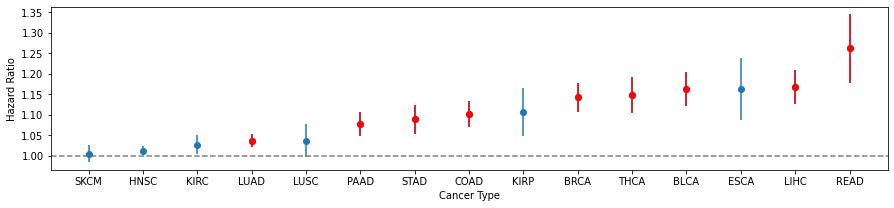

In [38]:
haz_plot_=hazard_list
haz_plot_.index=cancer_list
haz_plot_["Cancer Type"]=cancer_list
#haz_plot_=haz_plot_.drop(haz_plot_.index[abs(haz_plot_["coef"])>1][0])
haz_plot_=haz_plot_.drop(["KICH"])
haz_plot_=fdr(haz_plot_,False,"p")
haz_plot_=haz_plot_.sort_values(by="exp(coef)",ascending=True)
plt.figure(figsize=(15,3))
plt.errorbar(x=haz_plot_["Cancer Type"].tolist(),y=haz_plot_["exp(coef)"].tolist(),yerr=haz_plot_["se(coef)"].tolist(),fmt="o")
haz_plot_thresh=haz_plot_[haz_plot_["fdr"]<0.05]
plt.errorbar(x=haz_plot_thresh["Cancer Type"].tolist(),y=haz_plot_thresh["exp(coef)"].tolist(),yerr=haz_plot_thresh["se(coef)"].tolist(),fmt="o",color="red")
plt.xlabel("Cancer Type")
plt.ylabel("Hazard Ratio")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/cancer_risk_PFI_hazardV2_long.pdf")